**Describe the problem you want to solve using data science techniques. Why is it important? How your ML model can help (e.g., reduce costs, increase quality, etc.)? (6 points)**


**Load the data using pandas and split the data frame into X (inputs) and y (outputs). (2 points)**


**Prepare your dataset: encode categorical variables (if any), handle missing variables (if any), generate new features (if you have some intuition that these features can be useful). Preprocess target variable if needed (e.g., combine various classification problems into a single one or convert the target variable to a binary one.) For each transformation give a clear explanation of your motivation. (7 points)**


**Perform an exploratory analysis of the data via visualization with Seaborn. Try to find meaningful patterns in the data which can be used to make machine learning task more specific or to help with selection and tuning ML models. Perform additional preprocessing of your data if your findings suggest this (again, all steps should be motivated). If there are several options for target variables, you can select some of them after this step with a couple of sentences explaining your choice. (6 points).**


**Build a proper cross-validation procedure; select an appropriate measure of quality (the selection of both things should be motivated by your data). Choose an ML model reasonably; look for a good set of hyperparameters. Use the prepared cross-validation procedure to estimate the quality of prediction (9 points).**


**Analyze the obtained results (interesting findings, remarks on ML experiments, the applicability of the model in a real-life scenario) and make an overall conclusion. Does your model solve the problem stated at the beginning? Can you estimate the impact of your ML model on the problem domain (10 points)?** 

**Also, we'll estimate the structure and clarity of your presentations (10 points)**

1) Describe the problem you want to solve using data science techniques. Why is it important? How your ML model can help (e.g., reduce costs, increase quality, etc.)?

Road traffic collisions are the number one killer of children and young adults ages 5-29, and 8th leading cause of death worldwide. Post-crash care is one of the five pillars of road safety and a critical component for reducing morbidity and mortality.

When it comes to emergency response to road accidents, every second counts. With heavy traffic patterns and the unique layout of the city, finding the best locations to position emergency responders throughout the day as they wait to be called is critical in a city like Nairobi.


Our model can help reduce the number of seconds for first aid to road traffic accident victims.

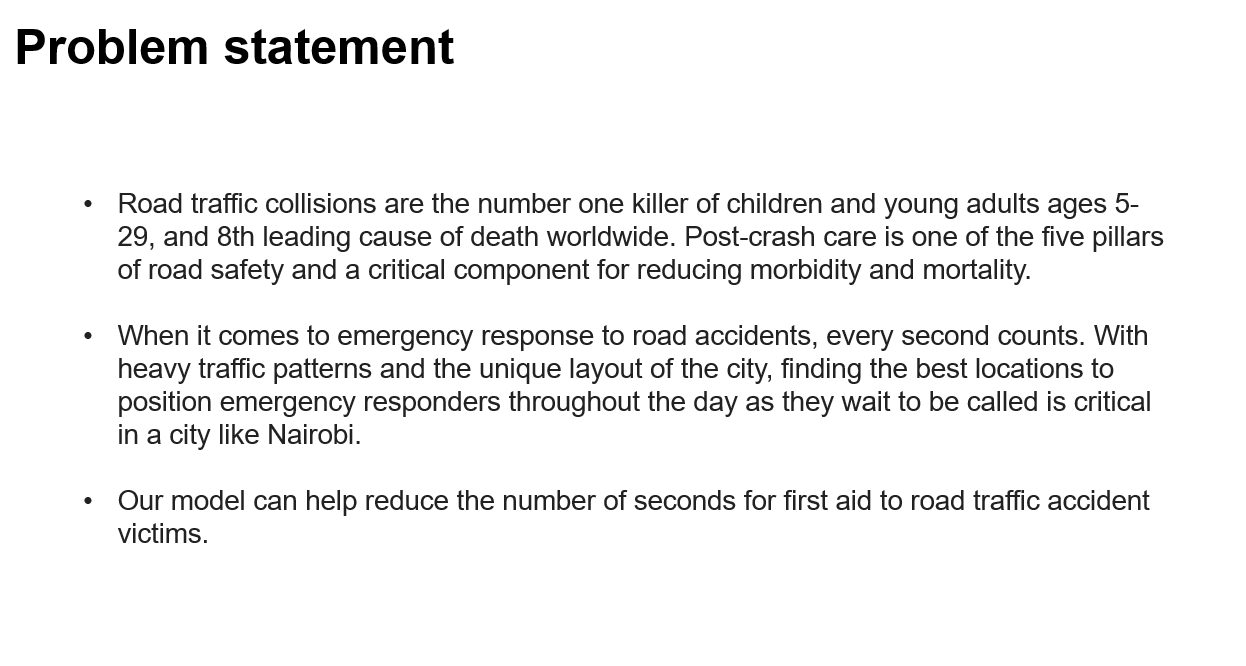

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
!pip install geopandas
import geopandas as gpd # For loading the map of road segments
import seaborn as sns
import matplotlib.pyplot as plt

# The Challenge

The main dataset for this challenge (in Train.csv) is a record of crashes within Nairobi over 2018-19. Each crash has an associated datetime and location. Let's load the data and take a look.

2) Load the data using pandas and split the data frame into X (inputs) and y (outputs). (2 points)

In [3]:
# Load the data
df = pd.read_csv('/content/drive/My Drive/uber/Train.csv', parse_dates=['datetime'])
print(df.shape)
df.head()

(6318, 4)


,uid,datetime,latitude,longitude
0,1,2018-01-01 00:25:46,-1.188850,36.931382
1,2,2018-01-01 02:02:39,-0.662939,37.208730
2,3,2018-01-01 02:31:49,-0.662939,37.208730
3,4,2018-01-01 03:04:01,-1.288087,36.826583
4,5,2018-01-01 03:58:49,-1.188850,36.931382


3) Prepare your dataset: encode categorical variables (if any), handle missing variables (if any), generate new features (if you have some intuition that these features can be useful). Preprocess target variable if needed (e.g., combine various classification problems into a single one or convert the target variable to a binary one.) For each transformation give a clear explanation of your motivation. (7 points)

In [4]:
df.dtypes

uid                   int64
datetime     datetime64[ns]
latitude            float64
longitude           float64
dtype: object

In [5]:
df.isnull().sum()

uid          0
datetime     0
latitude     0
longitude    0
dtype: int64

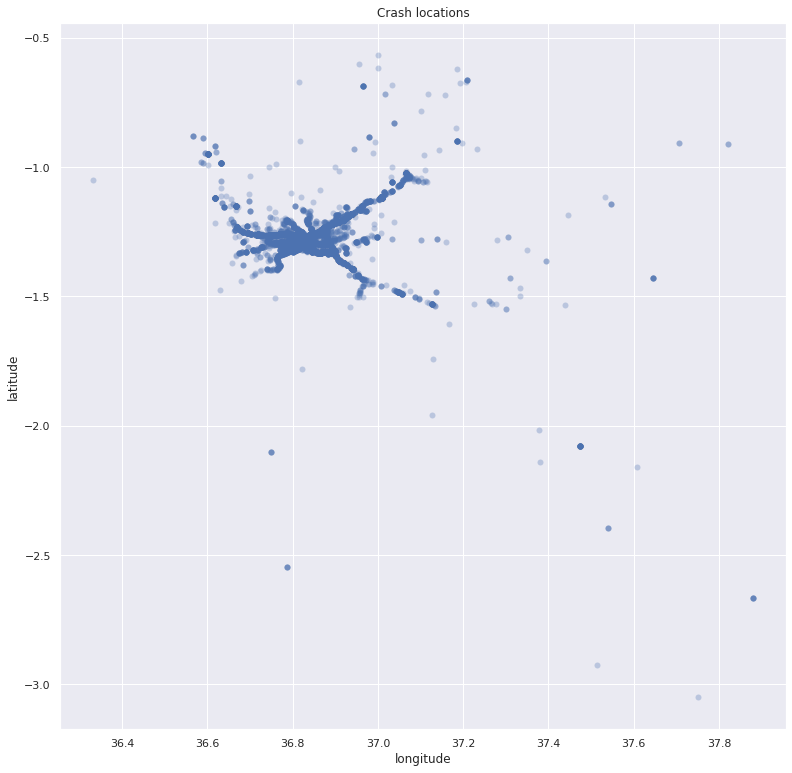

In [6]:
sns.set_theme(style="darkgrid")
f, ax = plt.subplots(figsize=(13, 13))
ax.set_title('Crash locations')
sns.scatterplot(x='longitude', y='latitude',linewidth=0,data=df, ax=ax,alpha=0.3);

Rather than trying to predict accident locations or the number of accidents in a given timeframe, we are instead asked to come up with an ambulance deployment schedule that will minimise distance travelled. 

This is of course a simplification of the problem, but by solving this you will hopefully develop strategies that can be used going forward.

In [7]:
# View the submission format
ss = pd.read_csv('/content/drive/My Drive/uber/SampleSubmission.csv', parse_dates=['date'])
ss.head()

,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude
0,2019-07-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0
1,2019-07-01 03:00:00,0,0,0,0,0,0,0,0,0,0,0,0
2,2019-07-01 06:00:00,0,0,0,0,0,0,0,0,0,0,0,0
3,2019-07-01 09:00:00,0,0,0,0,0,0,0,0,0,0,0,0
4,2019-07-01 12:00:00,0,0,0,0,0,0,0,0,0,0,0,0


How much days we need to predict?

In [8]:
ss.shape[0]//8

184

## Scoring

You can re-create the scoring process by creating your own test set and using the following function:

In [9]:
def score(sub, ref):
    total_distance = 0
    for date, c_lat, c_lon in ref[['datetime', 'latitude', 'longitude']].values:
        row = sub.loc[sub.date < date].tail(1) # Prior to Oct 2 this was incorrectly .head(1)
        dists = []
        for a in range(6):
            dist = ((c_lat - row[f'A{a}_Latitude'].values[0])**2+(c_lon - row[f'A{a}_Longitude'].values[0])**2)**0.5 
            dists.append(dist)
        total_distance += min(dists)
    return total_distance


This scoring function can be used for local testing without needing to submit on Zindi. Lower is better. Experiment with specifying set locations for all 6 ambulances, and see how low you can get your score.

In [10]:
!pip install contextily
import contextily as ctx

In [11]:
df.head()

,uid,datetime,latitude,longitude
0,1,2018-01-01 00:25:46,-1.188850,36.931382
1,2,2018-01-01 02:02:39,-0.662939,37.208730
2,3,2018-01-01 02:31:49,-0.662939,37.208730
3,4,2018-01-01 03:04:01,-1.288087,36.826583
4,5,2018-01-01 03:58:49,-1.188850,36.931382


In [12]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf = gdf.set_crs(epsg=4326)
gdf.head()

,uid,datetime,latitude,longitude,geometry
0,1,2018-01-01 00:25:46,-1.188850,36.931382,POINT (36.93138 -1.18885)
1,2,2018-01-01 02:02:39,-0.662939,37.208730,POINT (37.20873 -0.66294)
2,3,2018-01-01 02:31:49,-0.662939,37.208730,POINT (37.20873 -0.66294)
3,4,2018-01-01 03:04:01,-1.288087,36.826583,POINT (36.82658 -1.28809)
4,5,2018-01-01 03:58:49,-1.188850,36.931382,POINT (36.93138 -1.18885)


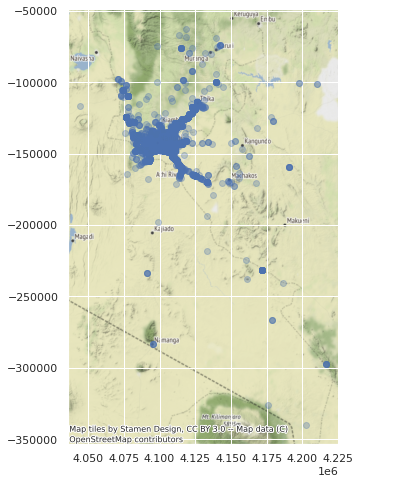

In [13]:
# set format for representing on map
# Load the data using pandas and split the data frame into X (inputs) and y (outputs). (2 points)

df_crs = gdf.to_crs(epsg=3857)
ax = df_crs.plot(figsize=(20, 8), alpha=0.3)
ctx.add_basemap(ax)

In [14]:
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering

Clusterization using K-Means method

## First approach - baseline clear K-means on full data

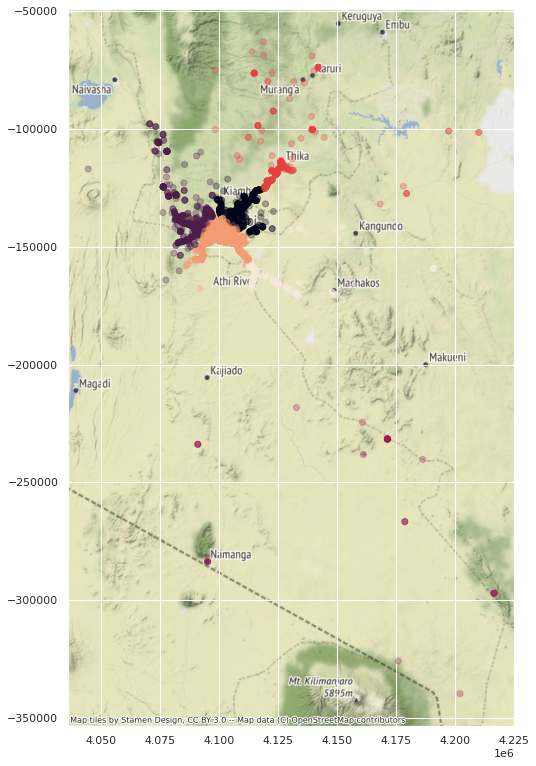

In [15]:
km_fit_wo = KMeans(n_clusters=6, random_state=42).fit(df_crs[["longitude", "latitude"]])
y_pred_wo = km_fit_wo.predict(df_crs[["longitude", "latitude"]])
ax = df_crs.plot(figsize=(8, 20), alpha=0.3, c=y_pred_wo)
ctx.add_basemap(ax)

In [16]:
reference = df_crs.loc[df.datetime > '2019-01-01'] # Using 2019 as our test set
# Create submission dataframe

# Date rane covering test set
dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')
sub = pd.DataFrame({
    'date':dates
})

for ambulance in range(6):
    sub['A'+str(ambulance)+'_Latitude'] = sub.apply(lambda x: km_fit_wo.cluster_centers_[ambulance][1], axis=1)
    sub['A'+str(ambulance)+'_Longitude'] = sub.apply(lambda x: km_fit_wo.cluster_centers_[ambulance][0], axis=1)


sub.head()

,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude
0,2019-01-01 00:00:00,-1.212403,36.906108,-1.234915,36.725122,-2.269933,37.385892,-1.021416,37.061628,-1.304405,36.842114,-1.465775,37.074946
1,2019-01-01 03:00:00,-1.212403,36.906108,-1.234915,36.725122,-2.269933,37.385892,-1.021416,37.061628,-1.304405,36.842114,-1.465775,37.074946
2,2019-01-01 06:00:00,-1.212403,36.906108,-1.234915,36.725122,-2.269933,37.385892,-1.021416,37.061628,-1.304405,36.842114,-1.465775,37.074946
3,2019-01-01 09:00:00,-1.212403,36.906108,-1.234915,36.725122,-2.269933,37.385892,-1.021416,37.061628,-1.304405,36.842114,-1.465775,37.074946
4,2019-01-01 12:00:00,-1.212403,36.906108,-1.234915,36.725122,-2.269933,37.385892,-1.021416,37.061628,-1.304405,36.842114,-1.465775,37.074946


In [17]:
score(sub, reference)

106.70230510168582

## Remove some anomaly crashes

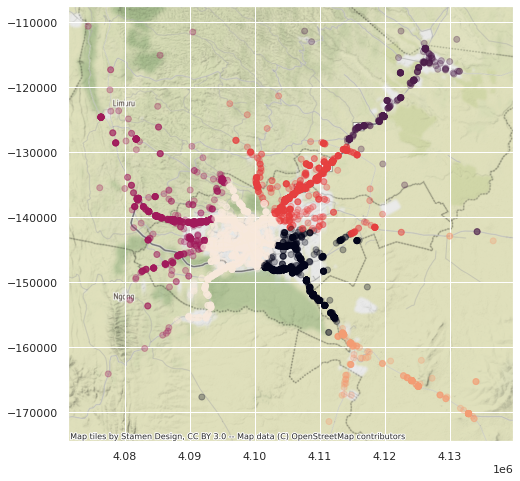

In [18]:
df_crs_clipped = df_crs[(df_crs.geometry.x > 4060000) & (df_crs.geometry.x < 4137000) &  (df_crs.geometry.y < -110000) &  (df_crs.geometry.y > -175000)]
km_fit = KMeans(n_clusters=6, random_state=42).fit(df_crs_clipped[["longitude", "latitude"]])
y_pred = km_fit.predict(df_crs_clipped[["longitude", "latitude"]])
ax = df_crs_clipped.plot(figsize=(20, 8), alpha=0.3, c=y_pred)
ctx.add_basemap(ax)


In [19]:
reference = df_crs.loc[df.datetime > '2019-01-01'] # Using 2019 as our test set
# Create submission dataframe

# Date rane covering test set
dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')
sub = pd.DataFrame({
    'date':dates
})

for ambulance in range(6):
    sub['A'+str(ambulance)+'_Latitude'] = sub.apply(lambda x: km_fit.cluster_centers_[ambulance][1], axis=1)
    sub['A'+str(ambulance)+'_Longitude'] = sub.apply(lambda x: km_fit.cluster_centers_[ambulance][0], axis=1)


sub.head()
score(sub, reference)

93.05345037826604

## Remove more

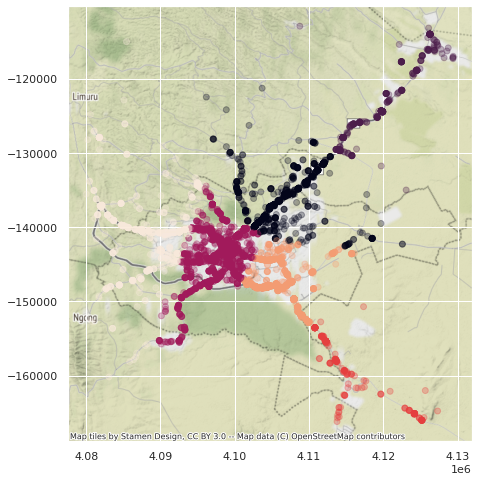

In [20]:
df_crs_clipped_more = df_crs[(df_crs.geometry.x > 4080000) & (df_crs.geometry.x < 4130000) &  (df_crs.geometry.y < -112000) &  (df_crs.geometry.y > -167000)]
km3 = KMeans(n_clusters=6, random_state=42).fit(df_crs_clipped_more[["longitude", "latitude"]])
y_pred = km3.predict(df_crs_clipped_more[["longitude", "latitude"]])
ax = df_crs_clipped_more.plot(figsize=(20, 8), alpha=0.3, c=y_pred)
ctx.add_basemap(ax)

In [21]:
km3.cluster_centers_

array([[36.89061405, -1.22311429],
       [37.0105096 , -1.10549191],
       [36.81394214, -1.29036795],
       [36.97286139, -1.4291357 ],
       [36.88173951, -1.32511679],
       [36.72959164, -1.26094473]])

In [22]:
reference = df_crs.loc[df.datetime > '2019-01-01'] # Using 2019 as our test set
# Create submission dataframe

# Date rane covering test set
dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')
sub = pd.DataFrame({
    'date':dates
})

for ambulance in range(6):
    sub['A'+str(ambulance)+'_Latitude'] = sub.apply(lambda x: km3.cluster_centers_[ambulance][1], axis=1)
    sub['A'+str(ambulance)+'_Longitude'] = sub.apply(lambda x: km3.cluster_centers_[ambulance][0], axis=1)


score(sub, reference)

93.65799771411096

## Seasonal approach

In [23]:
#Seasonal approach
df_crs_clipped_q1 = df_crs_clipped[df_crs_clipped.datetime.dt.month <= 3]
df_crs_clipped_q2 = df_crs_clipped[(df_crs_clipped.datetime.dt.month <= 6) & (df_crs_clipped.datetime.dt.month > 3)]
df_crs_clipped_q3 = df_crs_clipped[(df_crs_clipped.datetime.dt.month <= 9) & (df_crs_clipped.datetime.dt.month > 6)]
df_crs_clipped_q4 = df_crs_clipped[(df_crs_clipped.datetime.dt.month <= 12) & (df_crs_clipped.datetime.dt.month > 9)]

In [24]:
km_fit_q1 = KMeans(n_clusters=6, random_state=42).fit(df_crs_clipped_q1[["longitude", "latitude"]])
km_fit_q2 = KMeans(n_clusters=6, random_state=42).fit(df_crs_clipped_q2[["longitude", "latitude"]])
km_fit_q3 = KMeans(n_clusters=6, random_state=42).fit(df_crs_clipped_q3[["longitude", "latitude"]])
km_fit_q4 = KMeans(n_clusters=6, random_state=42).fit(df_crs_clipped_q4[["longitude", "latitude"]])

In [25]:
reference = df_crs.loc[df.datetime > '2019-01-01'] # Using 2019 as our test set
# Create submission dataframe

# Date rane covering test set
dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')
sub = pd.DataFrame({
    'date':dates
})

quartal_centroids = [km_fit_q1.cluster_centers_, km_fit_q2.cluster_centers_,km_fit_q3.cluster_centers_,km_fit_q4.cluster_centers_]
def quartal_clustering(ambulance, axis):
  def inner_quartal_clustering(row):
    quartal = (row.date.month - 1) // 4
    return quartal_centroids[quartal][ambulance][axis]
  return inner_quartal_clustering

for ambulance in range(6):
    sub['A'+str(ambulance)+'_Latitude'] = sub.apply(quartal_clustering(ambulance, 1), axis=1)
    sub['A'+str(ambulance)+'_Longitude'] = sub.apply(quartal_clustering(ambulance, 0), axis=1)


sub.tail()


,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude
2916,2019-12-31 12:00:00,-1.244531,36.717403,-1.329805,36.879595,-1.074473,37.035409,-1.289689,36.811613,-1.215209,36.899068,-1.435593,36.983550
2917,2019-12-31 15:00:00,-1.244531,36.717403,-1.329805,36.879595,-1.074473,37.035409,-1.289689,36.811613,-1.215209,36.899068,-1.435593,36.983550
2918,2019-12-31 18:00:00,-1.244531,36.717403,-1.329805,36.879595,-1.074473,37.035409,-1.289689,36.811613,-1.215209,36.899068,-1.435593,36.983550
2919,2019-12-31 21:00:00,-1.244531,36.717403,-1.329805,36.879595,-1.074473,37.035409,-1.289689,36.811613,-1.215209,36.899068,-1.435593,36.983550
2920,2020-01-01 00:00:00,-1.284257,36.816501,-1.075761,37.040626,-1.327039,36.887698,-1.256778,36.718892,-1.483127,37.036179,-1.210136,36.904431


In [26]:
score(sub, reference)

93.02803496559878

## Every 6 hours

In [27]:
df_crs_clipped_more_morning = df_crs_clipped_more[df_crs_clipped_more.datetime.dt.hour <= 6]
df_crs_clipped_more_day = df_crs_clipped_more[(df_crs_clipped_more.datetime.dt.hour <= 12) & (df_crs_clipped_more.datetime.dt.hour > 6)]
df_crs_clipped_more_evening = df_crs_clipped_more[(df_crs_clipped_more.datetime.dt.hour <= 18) & (df_crs_clipped_more.datetime.dt.hour > 12)]
df_crs_clipped_more_night = df_crs_clipped_more[(df_crs_clipped_more.datetime.dt.hour <= 24) & (df_crs_clipped_more.datetime.dt.hour > 18)]

In [28]:
km_fit_1 = KMeans(n_clusters=6, random_state=42).fit(df_crs_clipped_more_morning[["longitude", "latitude"]])
km_fit_2 = KMeans(n_clusters=6, random_state=42).fit(df_crs_clipped_more_day[["longitude", "latitude"]])
km_fit_3 = KMeans(n_clusters=6, random_state=42).fit(df_crs_clipped_more_evening[["longitude", "latitude"]])
km_fit_4 = KMeans(n_clusters=6, random_state=42).fit(df_crs_clipped_more_night[["longitude", "latitude"]])

In [29]:
reference = df_crs.loc[df.datetime > '2019-01-01'] # Using 2019 as our test set
# Create submission dataframe

# Date rane covering test set
dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')
sub = pd.DataFrame({
    'date':dates
})

daily_centroids = [km_fit_1.cluster_centers_, km_fit_2.cluster_centers_,km_fit_3.cluster_centers_,km_fit_4.cluster_centers_]
def quartal_clustering(ambulance, axis):
  def inner_quartal_clustering(row):
    quartal = (row.date.hour - 1) // 6
    return daily_centroids[quartal][ambulance][axis]
  return inner_quartal_clustering

for ambulance in range(6):
    sub['A'+str(ambulance)+'_Latitude'] = sub.apply(quartal_clustering(ambulance, 1), axis=1)
    sub['A'+str(ambulance)+'_Longitude'] = sub.apply(quartal_clustering(ambulance, 0), axis=1)


score(sub, reference)

93.07585018757075

## Every 3 hours different locations

In [30]:
#daily approach
df_crs_clipped_more_3 = df_crs_clipped_more[df_crs_clipped_more.datetime.dt.hour <= 3]
df_crs_clipped_more_6 = df_crs_clipped_more[(df_crs_clipped_more.datetime.dt.hour <= 6) & (df_crs_clipped_more.datetime.dt.hour > 3)]
df_crs_clipped_more_9 = df_crs_clipped_more[(df_crs_clipped_more.datetime.dt.hour <= 9) & (df_crs_clipped_more.datetime.dt.hour > 6)]
df_crs_clipped_more_12 = df_crs_clipped_more[(df_crs_clipped_more.datetime.dt.hour <= 12) & (df_crs_clipped_more.datetime.dt.hour > 9)]
df_crs_clipped_more_15 = df_crs_clipped_more[(df_crs_clipped_more.datetime.dt.hour <= 15) & (df_crs_clipped_more.datetime.dt.hour > 12)]
df_crs_clipped_more_18 = df_crs_clipped_more[(df_crs_clipped_more.datetime.dt.hour <= 18) & (df_crs_clipped_more.datetime.dt.hour > 15)]
df_crs_clipped_more_21 = df_crs_clipped_more[(df_crs_clipped_more.datetime.dt.hour <= 21) & (df_crs_clipped_more.datetime.dt.hour > 18)]
df_crs_clipped_more_24 = df_crs_clipped_more[(df_crs_clipped_more.datetime.dt.hour <= 24) & (df_crs_clipped_more.datetime.dt.hour > 21)]

In [31]:
km_fit_q1 = KMeans(n_clusters=6, random_state=42).fit(df_crs_clipped_more_3[["longitude", "latitude"]])
km_fit_q2 = KMeans(n_clusters=6, random_state=42).fit(df_crs_clipped_more_6[["longitude", "latitude"]])
km_fit_q3 = KMeans(n_clusters=6, random_state=42).fit(df_crs_clipped_more_9[["longitude", "latitude"]])
km_fit_q4 = KMeans(n_clusters=6, random_state=42).fit(df_crs_clipped_more_12[["longitude", "latitude"]])
km_fit_q5 = KMeans(n_clusters=6, random_state=42).fit(df_crs_clipped_more_15[["longitude", "latitude"]])
km_fit_q6 = KMeans(n_clusters=6, random_state=42).fit(df_crs_clipped_more_18[["longitude", "latitude"]])
km_fit_q7 = KMeans(n_clusters=6, random_state=42).fit(df_crs_clipped_more_21[["longitude", "latitude"]])
km_fit_q8 = KMeans(n_clusters=6, random_state=42).fit(df_crs_clipped_more_24[["longitude", "latitude"]])

In [32]:
reference = df_crs.loc[df.datetime > '2019-01-01'] # Using 2019 as our test set
# Create submission dataframe

# Date rane covering test set
dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')
sub = pd.DataFrame({
    'date':dates
})

daily_centroids = [km_fit_q1.cluster_centers_, km_fit_q2.cluster_centers_,km_fit_q3.cluster_centers_,km_fit_q4.cluster_centers_,km_fit_q5.cluster_centers_, km_fit_q6.cluster_centers_,km_fit_q7.cluster_centers_,km_fit_q8.cluster_centers_]
def quartal_clustering(ambulance, axis):
  def inner_quartal_clustering(row):
    quartal = (row.date.hour - 1) // 3
    return daily_centroids[quartal][ambulance][axis]
  return inner_quartal_clustering

for ambulance in range(6):
    sub['A'+str(ambulance)+'_Latitude'] = sub.apply(quartal_clustering(ambulance, 1), axis=1)
    sub['A'+str(ambulance)+'_Longitude'] = sub.apply(quartal_clustering(ambulance, 0), axis=1)



In [33]:
score(sub, reference)

94.28868793089342

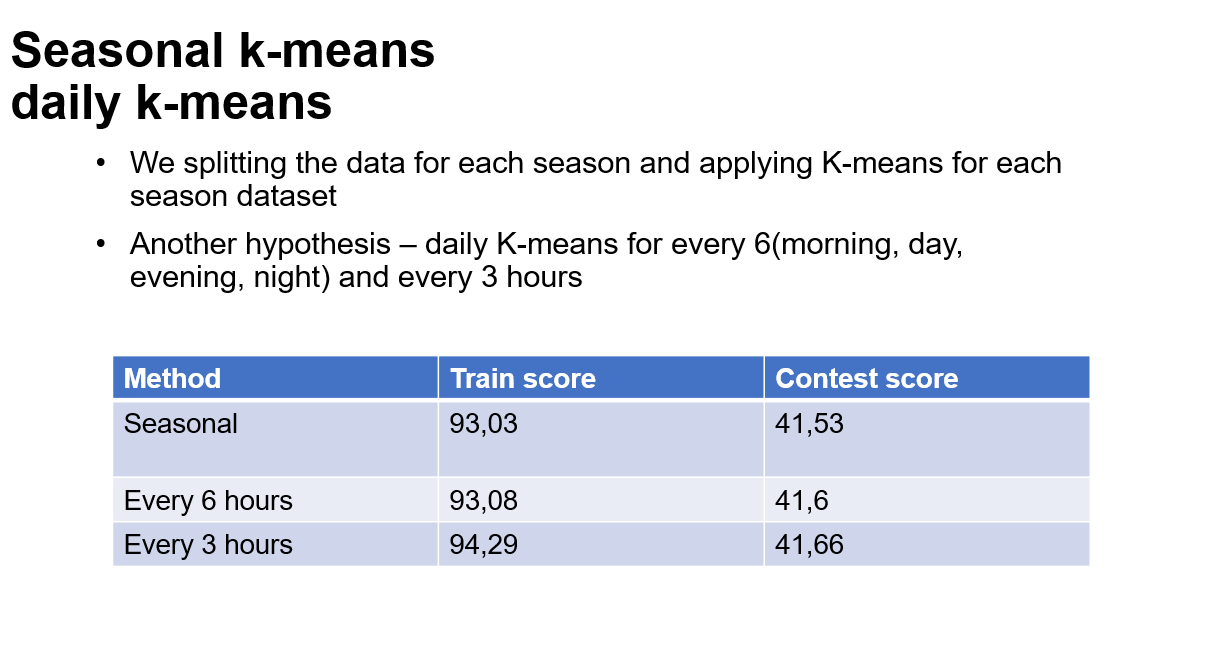

## Comparison with other clustering algorithms

### Agglomerative Clustering

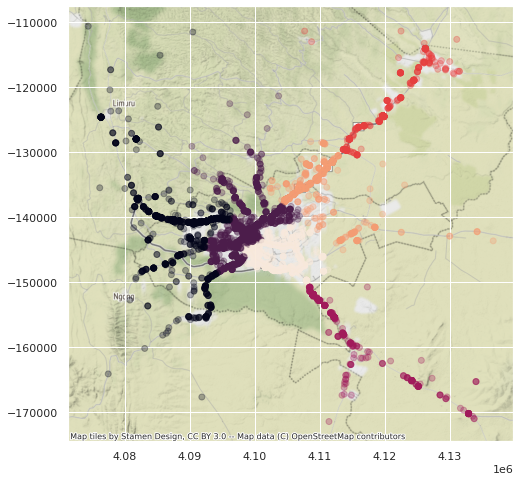

In [34]:
df_crs_clipped = df_crs[(df_crs.geometry.x > 4060000) & (df_crs.geometry.x < 4137000) &  (df_crs.geometry.y < -110000) &  (df_crs.geometry.y > -175000)]
agclust = AgglomerativeClustering(n_clusters=6)
y_pred = agclust.fit_predict(df_crs_clipped[["longitude", "latitude"]])
ax = df_crs_clipped.plot(figsize=(20, 8), alpha=0.3, c=y_pred)
ctx.add_basemap(ax)

In [35]:
y_pred_series = pd.Series(y_pred, name="cluster", dtype=str)
df_crs_with_pred = df_crs_clipped[["longitude", "latitude"]]
df_crs_with_pred["ambulance"] = y_pred_series
df_crs_with_pred.dropna(inplace=True)

df_crs_with_pred.isnull().sum()
ambulances_centers = {
    "0":{"count":0, "latitude":0,"longitude":0, "center":{"latitude":0, "longitude":0}},
    "1":{"count":0, "latitude":0,"longitude":0, "center":{"latitude":0, "longitude":0}},
    "2":{"count":0, "latitude":0,"longitude":0, "center":{"latitude":0, "longitude":0}},
    "3":{"count":0, "latitude":0,"longitude":0, "center":{"latitude":0, "longitude":0}},
    "4":{"count":0, "latitude":0,"longitude":0, "center":{"latitude":0, "longitude":0}},
    "5":{"count":0, "latitude":0,"longitude":0, "center":{"latitude":0, "longitude":0}}
}


for index, row in df_crs_with_pred.iterrows():
  # print(row)
  ambulances_centers[row["ambulance"]]["count"] += 1
  ambulances_centers[row["ambulance"]]["latitude"] += row["latitude"]
  ambulances_centers[row["ambulance"]]["longitude"] += row["longitude"]

for ambulance, position in ambulances_centers.items():
  position["center"]["latitude"] = position["latitude"]/position["count"]
  position["center"]["longitude"] = position["longitude"]/position["count"]

ambulances_centers


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


{'0': {'center': {'latitude': -1.2723909560018924,
   'longitude': 36.84797318545156},
  'count': 1087,
  'latitude': -1383.0889691740572,
  'longitude': 40053.74685258584},
 '1': {'center': {'latitude': -1.2718176670350985,
   'longitude': 36.84995385535143},
  'count': 1932,
  'latitude': -2457.1517327118104,
  'longitude': 71194.11084853896},
 '2': {'center': {'latitude': -1.2679101157908772,
   'longitude': 36.84285708863019},
  'count': 364,
  'latitude': -461.5192821478793,
  'longitude': 13410.79998026139},
 '3': {'center': {'latitude': -1.2688835204667082,
   'longitude': 36.85422441772022},
  'count': 368,
  'latitude': -466.9491355317486,
  'longitude': 13562.354585721041},
 '4': {'center': {'latitude': -1.2726579879630653,
   'longitude': 36.85206608560202},
  'count': 879,
  'latitude': -1118.6663714195345,
  'longitude': 32392.966089244175},
 '5': {'center': {'latitude': -1.2687273800954824,
   'longitude': 36.84747499449181},
  'count': 1286,
  'latitude': -1631.583410802

In [36]:
reference = df_crs.loc[df.datetime > '2019-01-01'] # Using 2019 as our test set
# Create submission dataframe

# Date rane covering test set
dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')
sub = pd.DataFrame({
    'date':dates
})

for ambulance in range(6):
    sub['A'+str(ambulance)+'_Latitude'] = sub.apply(lambda x: ambulances_centers[str(ambulance)]["center"]["latitude"], axis=1)
    sub['A'+str(ambulance)+'_Longitude'] = sub.apply(lambda x: ambulances_centers[str(ambulance)]["center"]["longitude"], axis=1)


sub.head()
score(sub, reference)

178.16150859763007

### Spectral Clustering

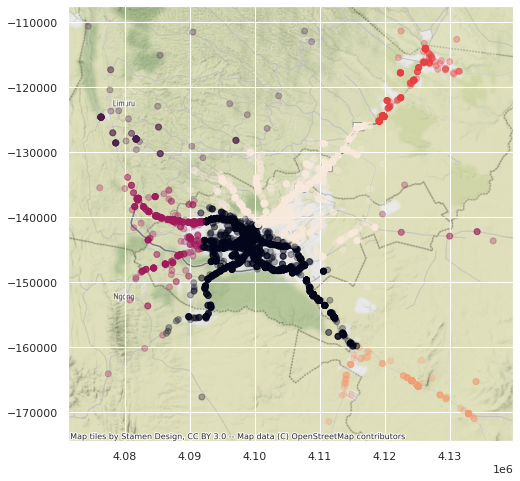

In [37]:
df_crs_clipped = df_crs[(df_crs.geometry.x > 4060000) & (df_crs.geometry.x < 4137000) &  (df_crs.geometry.y < -110000) &  (df_crs.geometry.y > -175000)]
specclust = SpectralClustering(n_clusters=6, random_state=42)
y_pred_spec = specclust.fit_predict(df_crs_clipped[["longitude", "latitude"]])
ax = df_crs_clipped.plot(figsize=(20, 8), alpha=0.3, c=y_pred_spec)
ctx.add_basemap(ax)

In [38]:
y_pred_series = pd.Series(y_pred_spec, name="cluster", dtype=str)
df_crs_with_pred = df_crs_clipped[["longitude", "latitude"]]
df_crs_with_pred["ambulance"] = y_pred_series
df_crs_with_pred.dropna(inplace=True)

df_crs_with_pred.isnull().sum()
ambulances_centers = {
    "0":{"count":0, "latitude":0,"longitude":0, "center":{"latitude":0, "longitude":0}},
    "1":{"count":0, "latitude":0,"longitude":0, "center":{"latitude":0, "longitude":0}},
    "2":{"count":0, "latitude":0,"longitude":0, "center":{"latitude":0, "longitude":0}},
    "3":{"count":0, "latitude":0,"longitude":0, "center":{"latitude":0, "longitude":0}},
    "4":{"count":0, "latitude":0,"longitude":0, "center":{"latitude":0, "longitude":0}},
    "5":{"count":0, "latitude":0,"longitude":0, "center":{"latitude":0, "longitude":0}}
}


for index, row in df_crs_with_pred.iterrows():
  # print(row)
  ambulances_centers[row["ambulance"]]["count"] += 1
  ambulances_centers[row["ambulance"]]["latitude"] += row["latitude"]
  ambulances_centers[row["ambulance"]]["longitude"] += row["longitude"]

for ambulance, position in ambulances_centers.items():
  position["center"]["latitude"] = position["latitude"]/position["count"]
  position["center"]["longitude"] = position["longitude"]/position["count"]

ambulances_centers

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


{'0': {'center': {'latitude': -1.27051564673005,
   'longitude': 36.848147191555356},
  'count': 2963,
  'latitude': -3764.537861261138,
  'longitude': 109181.06012857852},
 '1': {'center': {'latitude': -1.273042528550589,
   'longitude': 36.85700123724866},
  'count': 90,
  'latitude': -114.57382756955302,
  'longitude': 3317.1301113523796},
 '2': {'center': {'latitude': -1.271698411385537,
   'longitude': 36.84731493762759},
  'count': 615,
  'latitude': -782.0945230021052,
  'longitude': 22661.098686640966},
 '3': {'center': {'latitude': -1.2706080402616147,
   'longitude': 36.85970402095985},
  'count': 232,
  'latitude': -294.7810653406946,
  'longitude': 8551.451332862685},
 '4': {'center': {'latitude': -1.260424938098197,
   'longitude': 36.838373235622306},
  'count': 107,
  'latitude': -134.86546837650707,
  'longitude': 3941.7059362115865},
 '5': {'center': {'latitude': -1.2719256973482624,
   'longitude': 36.85038502023165},
  'count': 1909,
  'latitude': -2428.106156237833,

In [39]:
reference = df_crs.loc[df.datetime > '2019-01-01'] # Using 2019 as our test set
# Create submission dataframe

# Date rane covering test set
dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')
sub = pd.DataFrame({
    'date':dates
})

for ambulance in range(6):
    sub['A'+str(ambulance)+'_Latitude'] = sub.apply(lambda x: ambulances_centers[str(ambulance)]["center"]["latitude"], axis=1)
    sub['A'+str(ambulance)+'_Longitude'] = sub.apply(lambda x: ambulances_centers[str(ambulance)]["center"]["longitude"], axis=1)


sub.head()
score(sub, reference)

174.0611777359127

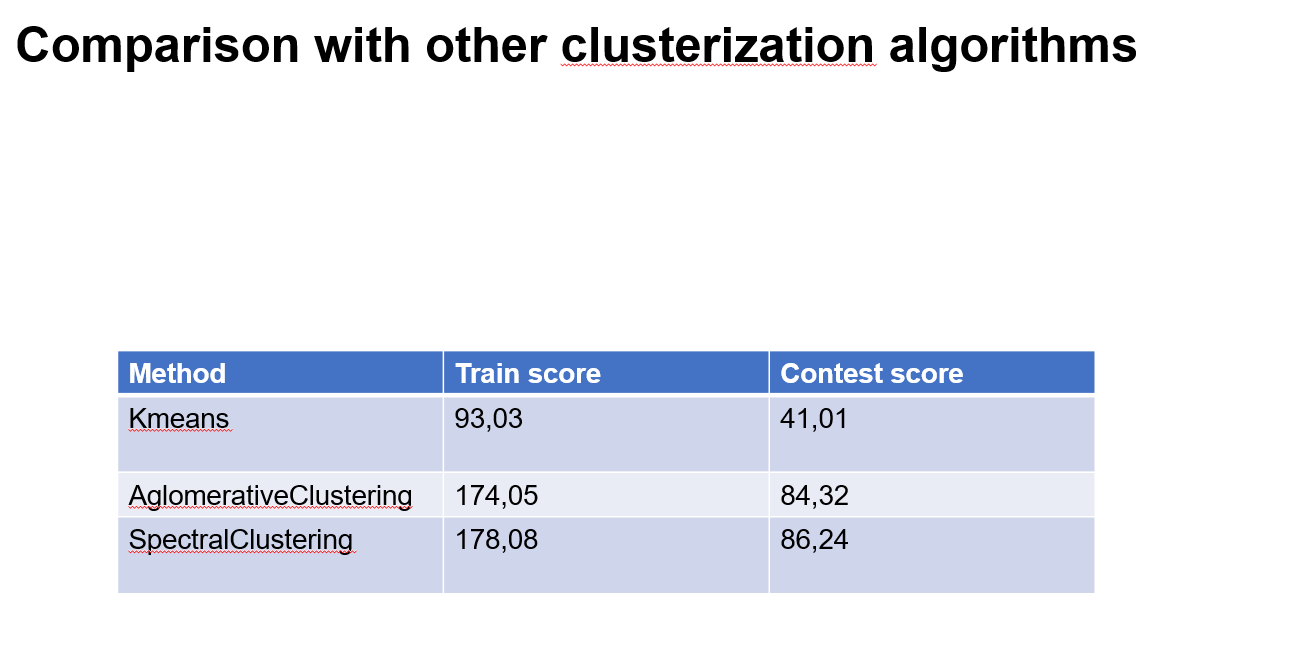

## Weather Data EDA

Some weather variables form the GFS dataset are provided, covering the greater Nairobi area. Let's take a quick look at the dataset before moving on:

In [40]:
weather = pd.read_csv('/content/drive/My Drive/uber/Weather_Nairobi_Daily_GFS.csv', parse_dates=['Date'])
weather.head()

,Date,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground
0,2018-01-01,24.100000,72.700005,0.009560,15.161493,-0.012186,-0.933914
1,2018-01-02,27.362288,74.900002,0.010463,16.047998,0.314543,-0.485459
2,2018-01-03,30.246618,86.599998,0.011930,15.838525,-0.282732,-0.653965
3,2018-01-04,33.010689,90.900002,0.012780,16.169244,0.211572,0.908123
4,2018-01-05,27.250372,82.413353,0.011392,15.923456,1.047275,-0.037742


In [41]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Date                                  731 non-null    datetime64[ns]
 1   precipitable_water_entire_atmosphere  728 non-null    float64       
 2   relative_humidity_2m_above_ground     728 non-null    float64       
 3   specific_humidity_2m_above_ground     728 non-null    float64       
 4   temperature_2m_above_ground           728 non-null    float64       
 5   u_component_of_wind_10m_above_ground  728 non-null    float64       
 6   v_component_of_wind_10m_above_ground  728 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 40.1 KB


In [42]:
weather.columns

Index(['Date', 'precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground',
       'specific_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground'],
      dtype='object')

In [43]:
weather.isnull().sum()

Date                                    0
precipitable_water_entire_atmosphere    3
relative_humidity_2m_above_ground       3
specific_humidity_2m_above_ground       3
temperature_2m_above_ground             3
u_component_of_wind_10m_above_ground    3
v_component_of_wind_10m_above_ground    3
dtype: int64

In [44]:
weather.dropna(inplace=True)

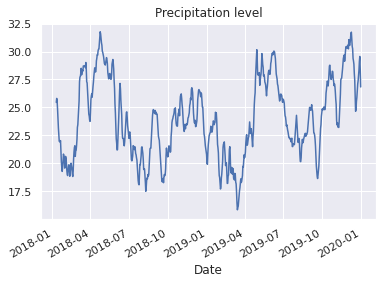

In [45]:
# Interestingly, Kenya has two rainy seasons per year!
weather.set_index('Date')['precipitable_water_entire_atmosphere'].rolling(10).mean().plot().set_title('Precipitation level');


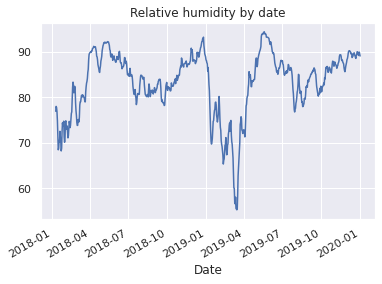

In [46]:
weather.set_index('Date')['relative_humidity_2m_above_ground'].rolling(10).mean().plot().set_title('Relative humidity by date');

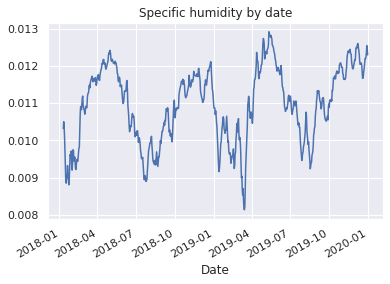

In [47]:
weather.set_index('Date')['specific_humidity_2m_above_ground'].rolling(10).mean().plot().set_title('Specific humidity by date');

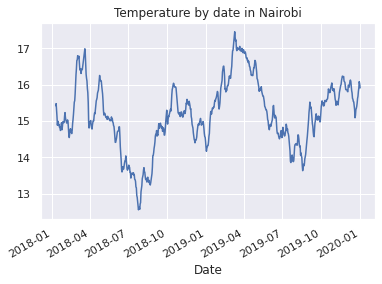

In [48]:
weather.set_index('Date')['temperature_2m_above_ground'].rolling(10).mean().plot().set_title('Temperature by date in Nairobi');

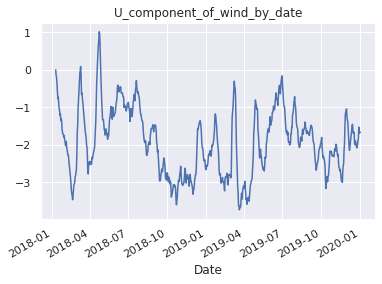

In [49]:
weather.set_index('Date')['u_component_of_wind_10m_above_ground'].rolling(10).mean().plot().set_title('U_component_of_wind_by_date');

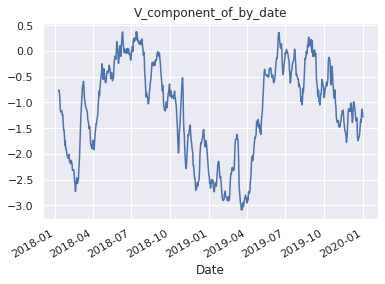

In [50]:
weather.set_index('Date')['v_component_of_wind_10m_above_ground'].rolling(10).mean().plot().set_title('V_component_of_by_date');

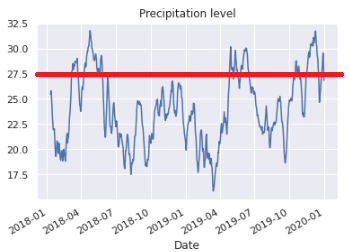

In [51]:
weather[weather['precipitable_water_entire_atmosphere'] > 27.5].count()

Date                                    181
precipitable_water_entire_atmosphere    181
relative_humidity_2m_above_ground       181
specific_humidity_2m_above_ground       181
temperature_2m_above_ground             181
u_component_of_wind_10m_above_ground    181
v_component_of_wind_10m_above_ground    181
dtype: int64

In [52]:
weather['high_rainfall'] = weather.precipitable_water_entire_atmosphere.apply(lambda x:1 if x > 27.5 else 0)
weather.head(10)

,Date,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,high_rainfall
0,2018-01-01,24.100000,72.700005,0.009560,15.161493,-0.012186,-0.933914,0
1,2018-01-02,27.362288,74.900002,0.010463,16.047998,0.314543,-0.485459,0
2,2018-01-03,30.246618,86.599998,0.011930,15.838525,-0.282732,-0.653965,1
3,2018-01-04,33.010689,90.900002,0.012780,16.169244,0.211572,0.908123,1
4,2018-01-05,27.250372,82.413353,0.011392,15.923456,1.047275,-0.037742,0
5,2018-01-06,24.300001,81.300003,0.010660,15.124994,-0.367690,-1.720410,0
6,2018-01-07,23.800001,74.735054,0.009575,14.816248,0.544004,-0.813267,0
7,2018-01-08,20.600630,64.900002,0.008180,14.496667,-0.003816,-1.861772,0
8,2018-01-09,21.786987,72.597282,0.009781,15.587091,-0.600393,-0.693701,0
9,2018-01-10,22.000000,68.073692,0.008876,15.062982,-0.884207,-1.480972,0


In [53]:
dayWithHighRainFall = weather[weather.high_rainfall == 1]
dayWithHighRainFall

,Date,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,high_rainfall
2,2018-01-03,30.246618,86.599998,0.011930,15.838525,-0.282732,-0.653965,1
3,2018-01-04,33.010689,90.900002,0.012780,16.169244,0.211572,0.908123,1
10,2018-01-11,27.700001,83.375984,0.011370,15.711389,-1.524686,-0.749463,1
50,2018-02-20,27.550373,87.200005,0.011890,15.649866,-2.474167,-1.977168,1
59,2018-03-01,32.299999,72.500748,0.011270,17.748132,0.798853,-0.790566,1
...,...,...,...,...,...,...,...,...
723,2019-12-25,31.800001,93.200005,0.013190,16.292383,-2.890862,-1.441726,1
724,2019-12-26,30.300001,91.900002,0.012820,16.063257,-1.340107,-0.403381,1
725,2019-12-27,29.300049,86.500000,0.012550,16.696375,-0.953635,-0.881265,1
726,2019-12-28,31.020416,87.099998,0.012772,16.854364,-0.930054,-1.511265,1


## Feature engineering - data augmentation

In [54]:
from datetime import datetime, timedelta
# if (datetime.today() - yourdate) == timedelta(0):
df_dupl = pd.DataFrame()
for i, row in df_crs.iterrows():
  for weather_index, weather in dayWithHighRainFall.iterrows():
    if (weather.Date.date() - row.datetime.date() == timedelta(0)):
      df_dupl = df_dupl.append(row)
      break
df_dupl.shape

(1573, 5)

In [55]:
df_doubled = pd.concat([df_crs, df_dupl])

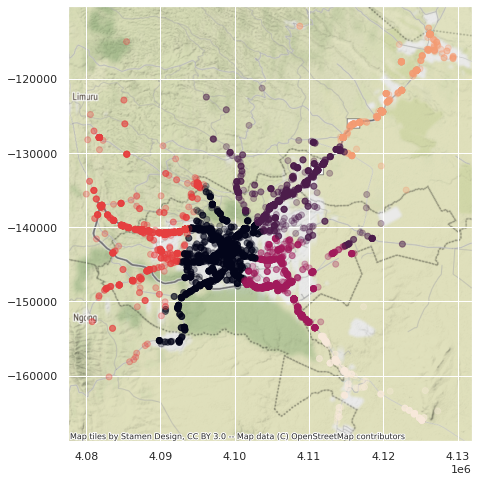

In [56]:
df_crs_clipped_more_doubled_hp = df_doubled[(df_doubled.geometry.x > 4080000) & (df_doubled.geometry.x < 4130000) &  (df_doubled.geometry.y < -112000) &  (df_doubled.geometry.y > -167000)]
km4 = KMeans(n_clusters=6, random_state=42).fit(df_crs_clipped_more_doubled_hp[["longitude", "latitude"]])
y_pred = km4.predict(df_crs_clipped_more_doubled_hp[["longitude", "latitude"]])
ax = df_crs_clipped_more_doubled_hp.plot(figsize=(20, 8), alpha=0.3, c=y_pred)
ctx.add_basemap(ax)

In [57]:
reference = df_crs.loc[df.datetime > '2019-01-01'] # Using 2019 as our test set
# Create submission dataframe

# Date rane covering test set
dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')
sub = pd.DataFrame({
    'date':dates
})

def is_day_high_rainfall(d):
  for weather_index, weather in dayWithHighRainFall.iterrows():
    if (weather.Date.date() - d.date() == timedelta(0)):
      return True
  return False

sub['high_rainfall'] = sub.date.apply(is_day_high_rainfall)

for ambulance in range(6):
    sub['A'+str(ambulance)+'_Latitude'] = sub.apply(lambda x: km4.cluster_centers_[ambulance][1] if x['high_rainfall'] == True else km3.cluster_centers_[ambulance][1], axis=1)
    sub['A'+str(ambulance)+'_Longitude'] = sub.apply(lambda x: km4.cluster_centers_[ambulance][0] if x['high_rainfall'] == True else km3.cluster_centers_[ambulance][0], axis=1)


score(sub, reference)

93.53316554393116

In [58]:
sub.drop(columns=["high_rainfall"], inplace=True)

In [59]:
sub.to_csv('/content/submission.csv')

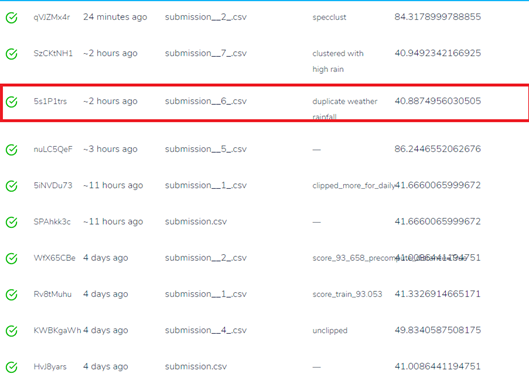

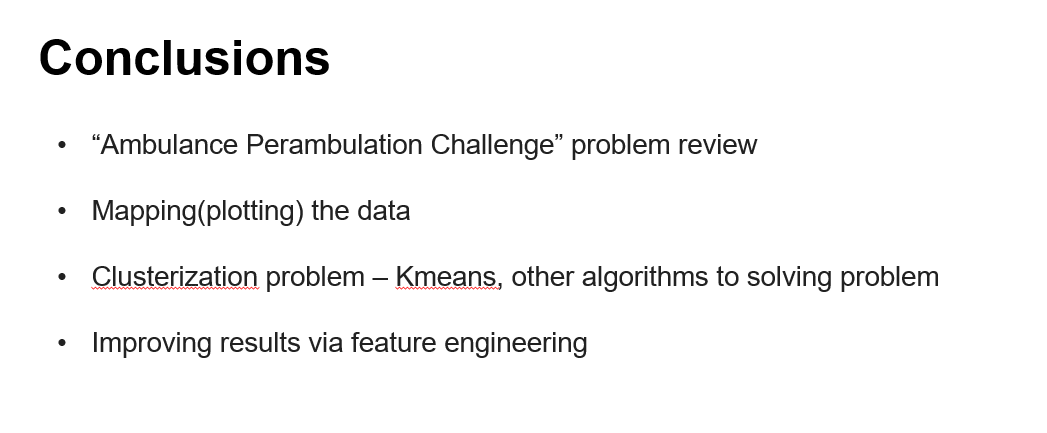